In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]


In [2]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/J_SHAP/non_hierarchical_bayesian_model/processed_inference.pkl"

with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
        y,
        subjects_inv,
        compound_positions_inv,
        compound_charge_params_inv,
    ) = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
a = posterior_samples['a']

/tmp/ipykernel_1014950/2474423707.py:29: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")


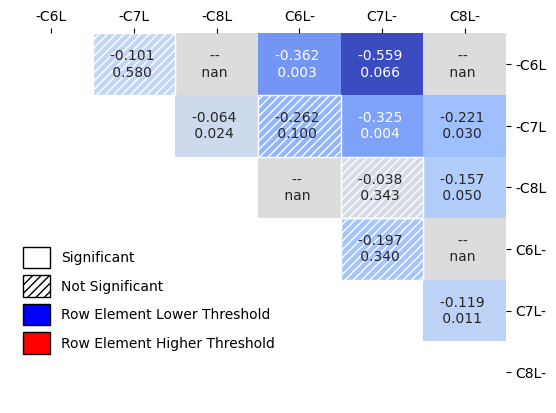

In [6]:
ind = [0,1,2,3,7,12]
labs = [compound_positions_inv[i] for i in ind]

### ACTUAL CALCULATION
a_test = a[:,:,ind,...]
a_test = a_test / ma.median(a_test, axis = (0,2,3,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(0, 3, -1))
a_mean.shape

t = (a_mean[:, :, None] - a_mean[:, None, :])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES
p = test.pvalue
### MASK NANs
# p_mean = p_mean[~p_mean.mask]
# p_mean = p_mean.reshape(len(ind),len(ind))

### GET VALUES WE WANT TO PLOT
# p_ = p[ind, :][:, ind]

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        
data = np.array(data).reshape(len(ind),len(ind))

#MASK LOWER TRIANGLE
mask2= np.array(p)
mask2 = np.tril(np.ones_like(mask2)).astype(bool)

#CORRECT LABELS
labels = np.array(labs)
labels = labels.astype('U20')

# if contact_ind == 0:
#     labels[ind] = labels[ind]
# else:
#     labels[ind] = np.char.add(labels[ind],"-M")

#PLOT
ax=sns.heatmap(p_mean, xticklabels=labels, yticklabels=labels,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p > 0.1

for i in range (p.shape[0]):
    for j in range(p.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
# ax.title.set_text(f"{contacts[contact_ind]}polar - Size: {size[size_ind]}")